In [1]:
# Change width of Jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint

# Section 9: Classification with Naive Bayes
This draws from the Module 12 notebooks and much from my own research and reading. I read countless Medium articles and several academic papers where I tried to implement some approaches to multiclass classification with text data. Frankly, much of it was over my head. 

DS5001 gave me an appreciation for exploring text data but because the class focused on unsupervised approaches, I do not feel comfortable with the supervised side of things. I learned a lot through the process of researching and implementing for this project but there are still some severe limitations on my ability to interact with this problem. 

The two biggest resources I utilized were Towards Data Science articles (huge shoutout to Susan Li) and the Google Developers documents on Keras.

In [3]:
df = pd.read_csv("2_df.csv").rename(columns={"Unnamed: 0":'company_num'})
OHCO = ['industry_num','company_num','sent_num','token_num']
VOCAB = pd.read_csv('VOCAB2.csv').rename(columns={"term_id":'token_num'}).set_index(OHCO[3])
LIB = pd.read_csv("LIB.csv").set_index(OHCO[1])
TOKEN = pd.read_csv('TOKEN2.csv').rename(columns={"Unnamed: 3":'token_num'}).set_index(OHCO)
TFIDF = pd.read_csv("TFIDF2.csv").set_index("industry_num")
DTCM = pd.read_csv("DTCM.csv").set_index("industry_num")
BOW = pd.read_csv("DOC2.csv")
SIGS = pd.read_csv("SIGS.csv")
WCM = pd.read_csv("WCM.csv")
tokens = pd.read_csv("3tokens.csv").set_index(OHCO)
sentences = pd.read_csv("3sentences.csv").set_index(OHCO[:3])
company_desc = pd.read_csv("3company_desc.csv").set_index(OHCO[:2])
industry_agg_desc = pd.read_csv("3industry_agg_desc.csv").set_index(OHCO[:1])

### Naive Bayes Classifier

In [4]:
df9 = company_desc.drop('desc_len',1).join(LIB["Industry_Index"], on='company_num', how='inner')
df9 = df9.rename(columns={"Industry_Index":"ind"})

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df9.content).toarray()
labels = df9.ind

features.shape

(12031, 17327)

In [11]:
# make a copy of the Industries column and save it to the company_industry variable
company_industry = df.loc[:,'Industry Groups'].copy()

# turn that object into a pandas dataframe
company_industry = pd.DataFrame(company_industry)

unique_inds = company_industry.copy()

# https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers
# change column to categorical
unique_inds['Industry Groups'] = pd.Categorical(unique_inds['Industry Groups'])

# now convert to codes and save down as new column
unique_inds['code'] = unique_inds['Industry Groups'].cat.codes
unique_inds = unique_inds.reset_index(drop=True)

In [12]:
y = pd.get_dummies(company_industry['Industry Groups']).values
X = features.copy()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df9['content'], df9['ind'], random_state = 0)
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [14]:
print(clf.predict(count_vect.transform(["ChiliSleep is a sleep technology brand focused on the future of sleep-driven health."])))

[16]


In [15]:
print(clf.predict(count_vect.transform(["It offers on-demand healthcare for people of all ages in the comfort of their own home."])))

[16]


In [16]:
print(clf.predict(count_vect.transform(["8base is a cloud-based platform where front-end developers can build and run enterprise-class web and mobile apps powered by GraphQL."])))

[16]


This is the problem with working with unbalanced datasets. Industry_Index==16 is by far the most dominant (see bar chart below), which means that the Naive Bays Classifier was trained more on that than on anything else, ultimately weighting things more as if they were part of Industry_Index==16 than any other industry classification.

In [17]:
# https://stackoverflow.com/questions/55132071/series-object-has-no-attribute-iplot/55132247
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


df9.groupby('ind').content.count().iplot(
    kind='bar'
)

# Multinomial Naive Bayes using a pipeline and the original dataframe

In [21]:
X = df['Full Description']
y = df['Industry Groups']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [24]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [25]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=df['Industry Groups'].unique()))

accuracy 0.3091412742382271
                         precision    recall  f1-score   support

          Manufacturing       0.93      0.07      0.13       206
   Privacy and Security       0.00      0.00      0.00        32
 Information Technology       0.00      0.00      0.00        25
  Professional Services       0.00      0.00      0.00        14
               Software       0.00      0.00      0.00        26
              Education       0.00      0.00      0.00        14
            Health Care       0.80      0.02      0.03       229
     Travel and Tourism       0.00      0.00      0.00        71
      Food and Beverage       0.00      0.00      0.00        13
         Transportation       0.00      0.00      0.00        14
   Clothing and Apparel       0.00      0.00      0.00        45
            Real Estate       0.00      0.00      0.00        64
Administrative Services       0.00      0.00      0.00         9
    Sales and Marketing       0.90      0.60      0.72       

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# LSTM Multi-Class Text Classification

Drew heavy inspiration from the MNIST Multi-class classification problem on Google Research Colab <br>
https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/multi-class_classification_with_MNIST.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=multiclass_tf2-colab&hl=en#scrollTo=nj3v5EKQFY8s

In [37]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

Using TensorFlow backend.


In [27]:
# https://stackoverflow.com/questions/55132071/series-object-has-no-attribute-iplot/55132247
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

df['Industry Groups'].value_counts().iplot(kind='bar')

In [50]:
# https://github.com/susanli2016/NLP-with-Python/blob/master/Doc2Vec%20Consumer%20Complaint.ipynb
    
from bs4 import BeautifulSoup
def cleanText(text):
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

df['Full Description'] = df['Full Description'].apply(cleanText)

In [51]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Full Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 40476 unique tokens.


In [52]:
X = tokenizer.texts_to_sequences(df['Full Description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (12031, 250)


In [53]:
Y = pd.get_dummies(df['Industry Groups']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (12031, 40)


In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(10827, 250) (10827, 40)
(1204, 250) (1204, 40)


In [55]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(40, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
Total params: 5,084,440
Trainable params: 5,084,440
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 9744 samples, validate on 1083 samples
Epoch 1/5
9744/9744 [==============================] - 158s 16ms/step - loss: 3.1295 - accuracy: 0.1692 - val_loss: 3.0949 - val_accuracy: 0.1727
Epoch 2/5
9744/9744 [==============================] - 168s 17ms/step - loss: 2.9900 - accuracy: 0.1959 - val_loss: 2.8361 - val_accuracy: 0.2595
Epoch 3/5
9744/9744 [==============================] - 174s 18ms/step - loss: 2.5419 - accuracy: 0.3417 - val_loss: 2.6753 - val_accuracy: 0.3343
Epoch 4/5
9744/9744 [==============================] - 180s 19ms/step - loss: 2.2232 - accuracy: 0.4156 - val_loss: 2.2770 - val_accuracy: 0.4109
Epoch 5/5
9744/9744 [==============================] - 183s 19ms/step - loss: 1.8826 - accuracy: 0.5005 - val_loss: 2.3398 - val_accuracy: 0.4100


In [57]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


1204/1204 [==============================] - 9s 8ms/step
Test set
  Loss: 2.301
  Accuracy: 0.419


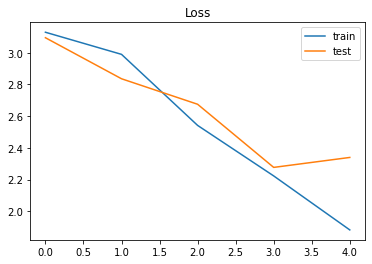

In [58]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


### Testing some examples:

In [59]:
df.sample(5)

,company_num,Organization Name,Industries,Industry Groups,Full Description
3528,2117,Palo Alto Networks,"Cyber Security, Network Security, Security",Information Technology,palo alto networks is the net-generation secur...
327,9534,SteadyMD,"Health Care, Medical, Wellness",Health Care,steadymd is a telehealth company that enables ...
10052,36622,Wolo,"Employee Benefits, Human Resources",Administrative Services,wolo is a new corporate rewards and recognitio...
6121,17390,Verimed,"Health Care, Supply Chain Management",Health Care,verimed is a technology company that works to ...
6329,18992,the Roadmap,"EdTech, Education, Enterprise Software, SaaS",Education,part learning method with the proven know : p...


In [63]:
df[df['company_num']==7034]['Full Description'].reset_index(drop=True)[0]

'vemo education is a mission-driven educational technology company focused on epanding educational access for all americans. we partner directly with colleges, universities, and other educational providers to design, implement, and sustain income share agreement (isa) programs to help increase educational opportunity and reduce financial barriers to economic mobility.'

In [64]:
new_complaint = ['vemo education is a mission-driven educational technology company focused on epanding educational access for all americans. we partner directly with colleges, universities, and other educational providers to design, implement, and sustain income share agreement (isa) programs to help increase educational opportunity and reduce financial barriers to economic mobility.']
seq = tokenizer.texts_to_sequences(new_complaint)

padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = df['Industry Groups'].values
print(pred, labels[np.argmax(pred)])

[[3.96285392e-03 2.54821219e-03 6.60113001e-04 1.54406216e-03
  4.58947645e-04 1.20471668e-04 2.34990148e-03 2.12845090e-03
  7.92109931e-04 3.32286407e-04 4.24690824e-03 3.20088211e-03
  4.47253464e-04 8.64397347e-01 3.73555487e-03 4.63256706e-03
  2.07282277e-03 9.26155073e-04 9.13505792e-04 2.11780876e-04
  7.47393863e-03 4.82071919e-04 1.33987376e-02 1.54748000e-02
  9.64994659e-04 3.39303369e-04 2.12197148e-04 2.65098606e-05
  7.56566733e-05 2.19694320e-02 7.05072947e-04 5.28852921e-03
  1.41791604e-03 6.89153047e-03 1.18864024e-04 2.00200956e-02
  1.59540994e-03 1.05796615e-04 6.70648937e-04 3.08631361e-03]] Manufacturing


**If it can't correctly classify an Education company where "education" is used multiple times and the words "college" and "universities" are in the description, then this model is useless.**

# Logistic Regression

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
import itertools
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline
#from yellowbrick.text import FreqDistVisualizer

In [6]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df['Industry Groups'].values)
X_train, X_test, y_train, y_test = train_test_split(df['Full Description'].values, y,
                                                   stratify=y, 
                                                   random_state=42, test_size=0.3)

In [7]:
tfidf = TfidfVectorizer(strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')
# Fit and transform Tf-idf to both training and test sets
tfidf.fit(list(X_train) + list(X_test))
X_train_tfidf =  tfidf.transform(X_train) 
X_test_tfidf = tfidf.transform(X_test)

In [9]:
target_names = lbl_enc.classes_

In [10]:
# len(lbl_enc.classes_)
# len(X_train['Industry Groups'].values)
len(df['Industry Groups'].unique())

40

## Fitting Logistic Regression on TF-IDF

In [11]:
X_train_tfidf.shape

(8421, 947820)

In [12]:
logregclf = LogisticRegression(max_iter=100000)
logregclf.fit(X_train_tfidf, y_train)
y_pred = logregclf.predict(X_test_tfidf)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with logreg: 0.4368421052631579
                         precision    recall  f1-score   support

Administrative Services       0.80      0.46      0.58       200
            Advertising       0.00      0.00      0.00        30
Agriculture and Farming       0.00      0.00      0.00        25
                   Apps       0.00      0.00      0.00        15
          Biotechnology       0.00      0.00      0.00        25
   Clothing and Apparel       0.00      0.00      0.00        11
  Commerce and Shopping       0.70      0.25      0.37       225
Community and Lifestyle       0.00      0.00      0.00        62
   Consumer Electronics       0.00      0.00      0.00        14
         Consumer Goods       0.00      0.00      0.00        20
 Content and Publishing       0.00      0.00      0.00        48
     Data and Analytics       0.00      0.00      0.00        67
                 Design       0.00      0.00      0.00         9
              Education  

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression with BOW

In [8]:
countvec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english', binary=True)
# Fit and transform CountVectorizer to both training and test sets
countvec.fit(list(X_train) + list(X_test))
X_train_countvec =  countvec.transform(X_train) 
X_test_countvec = countvec.transform(X_test)

In [13]:
logregclf = LogisticRegression()
logregclf.fit(X_train_countvec, y_train)
y_pred = logregclf.predict(X_test_countvec)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with logreg: 0.6155124653739612
                         precision    recall  f1-score   support

Administrative Services       0.63      0.69      0.66       200
            Advertising       0.50      0.33      0.40        30
Agriculture and Farming       0.00      0.00      0.00        25
                   Apps       0.00      0.00      0.00        15
          Biotechnology       1.00      0.28      0.44        25
   Clothing and Apparel       0.50      0.18      0.27        11
  Commerce and Shopping       0.53      0.55      0.54       225
Community and Lifestyle       0.46      0.10      0.16        62
   Consumer Electronics       0.00      0.00      0.00        14
         Consumer Goods       0.00      0.00      0.00        20
 Content and Publishing       0.79      0.48      0.60        48
     Data and Analytics       0.76      0.39      0.51        67
                 Design       0.00      0.00      0.00         9
              Education  

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# OneVsRest Classifier

In [14]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

svc = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('svc', SVC()),
              ])
svc.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('svc', SVC())])

In [16]:
from sklearn.multiclass import OneVsRestClassifier

#https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

svc = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('svc', SVC()),
              ])

clf = OneVsRestClassifier(svc).fit(X_train, y_train)


In [17]:
%%time
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=df['Industry Groups'].unique()))

accuracy 0.6476454293628808
                         precision    recall  f1-score   support

          Manufacturing       0.65      0.71      0.68       200
   Privacy and Security       0.54      0.47      0.50        30
 Information Technology       1.00      0.16      0.28        25
  Professional Services       0.00      0.00      0.00        15
               Software       1.00      0.28      0.44        25
              Education       0.67      0.55      0.60        11
            Health Care       0.56      0.52      0.54       225
     Travel and Tourism       0.67      0.06      0.12        62
      Food and Beverage       0.00      0.00      0.00        14
         Transportation       0.00      0.00      0.00        20
   Clothing and Apparel       0.74      0.65      0.69        48
            Real Estate       0.80      0.48      0.60        67
Administrative Services       0.00      0.00      0.00         9
    Sales and Marketing       0.68      0.92      0.78       

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Support Vector Classifier (SVC)

### Fitting SVC on TF-IDF

In [19]:
svd = decomposition.TruncatedSVD(n_components=200)
svd.fit(X_train_tfidf)
X_train_svd = svd.transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

scale = preprocessing.StandardScaler()
scale.fit(X_train_svd)
X_train_svd_scale = scale.transform(X_train_svd)
X_test_svd_scale = scale.transform(X_test_svd)

SVMclf = SVC()
SVMclf.fit(X_train_svd_scale, y_train)


SVC()

In [20]:
X_train_tfidf.shape, X_test_tfidf.shape, y_train.shape, y_test.shape, X_train_svd_scale.shape

((8421, 947820), (3610, 947820), (8421,), (3610,), (8421, 200))

In [21]:
y_pred = SVMclf.predict(X_test_svd_scale)
print("---Test Set Results---")
print("Accuracy with SVM after SVD and standardize: {}".format(accuracy_score(y_test, y_pred)))
# print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with SVM after SVD and standardize: 0.615235457063712


In [22]:
print(classification_report(y_test, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

Administrative Services       0.73      0.60      0.66       200
            Advertising       0.41      0.37      0.39        30
Agriculture and Farming       1.00      0.04      0.08        25
                   Apps       0.00      0.00      0.00        15
          Biotechnology       0.78      0.28      0.41        25
   Clothing and Apparel       0.50      0.09      0.15        11
  Commerce and Shopping       0.35      0.53      0.42       225
Community and Lifestyle       0.35      0.13      0.19        62
   Consumer Electronics       0.00      0.00      0.00        14
         Consumer Goods       0.00      0.00      0.00        20
 Content and Publishing       0.68      0.52      0.59        48
     Data and Analytics       0.85      0.42      0.56        67
                 Design       0.00      0.00      0.00         9
              Education       0.83      0.82      0.82       310
                 Energy 

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fitting SVC on BOW

In [23]:
svd = decomposition.TruncatedSVD(n_components=200)
svd.fit(X_train_countvec)
X_train_svd = svd.transform(X_train_countvec)
X_test_svd = svd.transform(X_test_countvec)

scale = preprocessing.StandardScaler()
scale.fit(X_train_svd)
X_train_svd_scale = scale.transform(X_train_svd)
X_test_svd_scale = scale.transform(X_test_svd)

SVMclf = SVC()
SVMclf.fit(X_train_svd_scale, y_train)
y_pred = SVMclf.predict(X_test_svd_scale)
print("---Test Set Results---")
print("Accuracy with SVM after SVD and standardize: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))


---Test Set Results---
Accuracy with SVM after SVD and standardize: 0.550415512465374
                         precision    recall  f1-score   support

Administrative Services       0.63      0.60      0.62       200
            Advertising       0.33      0.20      0.25        30
Agriculture and Farming       0.00      0.00      0.00        25
                   Apps       0.00      0.00      0.00        15
          Biotechnology       1.00      0.04      0.08        25
   Clothing and Apparel       0.00      0.00      0.00        11
  Commerce and Shopping       0.34      0.41      0.37       225
Community and Lifestyle       0.44      0.06      0.11        62
   Consumer Electronics       0.00      0.00      0.00        14
         Consumer Goods       0.00      0.00      0.00        20
 Content and Publishing       0.71      0.35      0.47        48
     Data and Analytics       0.70      0.42      0.52        67
                 Design       0.00      0.00      0.00         9
   

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest
### Fitting Random Forest on TF-IDF

In [24]:
RFclf = RandomForestClassifier()
RFclf.fit(X_train_tfidf, y_train)
y_pred = RFclf.predict(X_test_tfidf)

print("---Test Set Results---")
print("Accuracy with RF: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with RF: 0.5551246537396122
                         precision    recall  f1-score   support

Administrative Services       0.68      0.56      0.62       200
            Advertising       0.42      0.27      0.33        30
Agriculture and Farming       0.00      0.00      0.00        25
                   Apps       0.00      0.00      0.00        15
          Biotechnology       1.00      0.12      0.21        25
   Clothing and Apparel       0.50      0.27      0.35        11
  Commerce and Shopping       0.60      0.44      0.51       225
Community and Lifestyle       1.00      0.03      0.06        62
   Consumer Electronics       0.00      0.00      0.00        14
         Consumer Goods       0.00      0.00      0.00        20
 Content and Publishing       0.76      0.40      0.52        48
     Data and Analytics       0.82      0.13      0.23        67
                 Design       0.00      0.00      0.00         9
              Education      

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fitting Random Forest on BOW

In [25]:
RFclf = RandomForestClassifier()
RFclf.fit(X_train_countvec, y_train)

y_pred = RFclf.predict(X_test_countvec)
print("---Test Set Results---")
print("Accuracy with RF: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with RF: 0.5562326869806095
                         precision    recall  f1-score   support

Administrative Services       0.70      0.60      0.65       200
            Advertising       0.50      0.10      0.17        30
Agriculture and Farming       0.00      0.00      0.00        25
                   Apps       0.00      0.00      0.00        15
          Biotechnology       1.00      0.08      0.15        25
   Clothing and Apparel       0.67      0.36      0.47        11
  Commerce and Shopping       0.58      0.48      0.52       225
Community and Lifestyle       0.00      0.00      0.00        62
   Consumer Electronics       0.00      0.00      0.00        14
         Consumer Goods       0.00      0.00      0.00        20
 Content and Publishing       0.81      0.35      0.49        48
     Data and Analytics       0.78      0.21      0.33        67
                 Design       0.00      0.00      0.00         9
              Education      

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
print('training score:', f1_score(y_train, xgb.predict(X_train), average='macro'))
print('validation score:', f1_score(y_test, xgb.predict(X_test), average='macro'))


training score: 0.9980250493428112
validation score: 0.34633737605219295


# XGBoost

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import scipy
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [42]:
import xgboost as xgb
Xtr, Xte, ytr, yte = train_test_split(df['Full Description'].values, y,
                                                   stratify=y, 
                                                   random_state=42, test_size=0.3)

xgb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', xgb.XGBClassifier(objective='binary:logistic', seed=42)),
              ]).fit(Xtr, ytr)

In [45]:
xgb_prediction = xgb.predict(X_test)

from sklearn.metrics import f1_score, classification_report, accuracy_score

print('training score:', f1_score(ytr, xgb.predict(Xtr), average='macro'))
print('validation score:', f1_score(yte, xgb.predict(Xte), average='macro'))
print(classification_report(yte, xgb_prediction))

training score: 0.9980250493428112
validation score: 0.34633737605219295
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       200
           1       0.62      0.53      0.57        30
           2       0.75      0.12      0.21        25
           3       0.40      0.13      0.20        15
           4       0.83      0.40      0.54        25
           5       0.67      0.55      0.60        11
           6       0.39      0.48      0.43       225
           7       0.31      0.18      0.22        62
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        20
          10       0.64      0.56      0.60        48
          11       0.70      0.42      0.52        67
          12       0.00      0.00      0.00         9
          13       0.75      0.84      0.79       310
          14       0.77      0.77      0.77        98
          15       0.62      0.52      0.57        48
        

/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/holdenbruce/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
